In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import einops

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sg

from envelope_detector import FilterHilbertLayer, ComplexWaveletLayer

# FilterHilbertLayer

In [6]:
torch.manual_seed(1)

srate = 1000
n_channels = 10
freq = None
# bandwidth = None
bandwidth = 0.4
x = torch.randn(size=(n_channels, 3000,))

filter_hilbert = FilterHilbertLayer(
    n_channels=n_channels,
    kernel_size=251,
    srate=srate,
    fmin_init=20,
    fmax_init=150,
    freq=freq,
    bandwidth=bandwidth,
)

y_ = filter_hilbert(x, return_filtered=True)
y = filter_hilbert(x)

assert x.shape == y.shape
y_.mean().backward()
filter_hilbert.coef_freq.grad

tensor([-9.9996e-07,  9.8342e-07,  6.3293e-06,  6.2148e-07,  1.5946e-06,
         1.5153e-06,  5.9347e-08, -1.1136e-05,  1.2927e-07, -4.7208e-06])

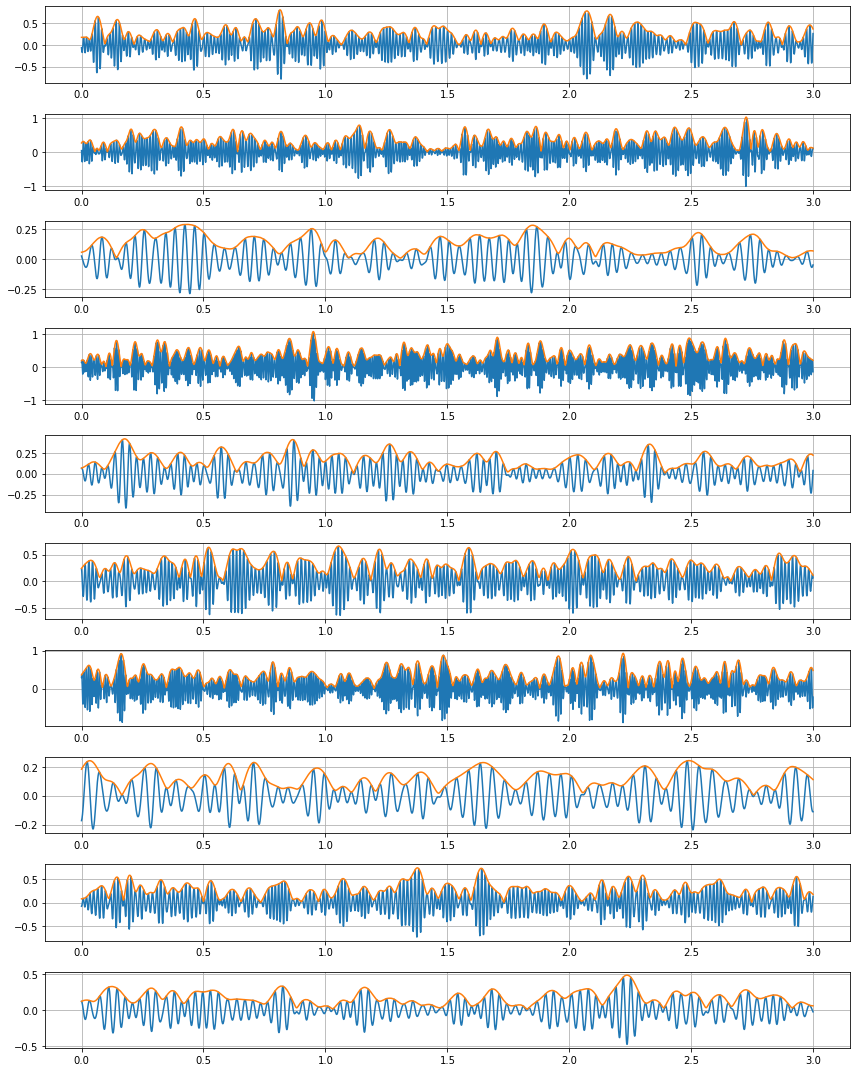

In [7]:
x_numpy = x.numpy()
y_numpy_ = y_.detach().numpy()
y_numpy = y.detach().numpy()
scale = np.arange(x_numpy.shape[-1]) / srate

fig, ax = plt.subplots(n_channels, 1, figsize=(12, 1.5*n_channels))
for i in range(n_channels):
    
    ax[i].plot(scale, y_numpy_[i])
    ax[i].plot(scale, y_numpy[i])
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    ax[i].set_title('')
    ax[i].grid(True)
    
plt.tight_layout()
plt.show()

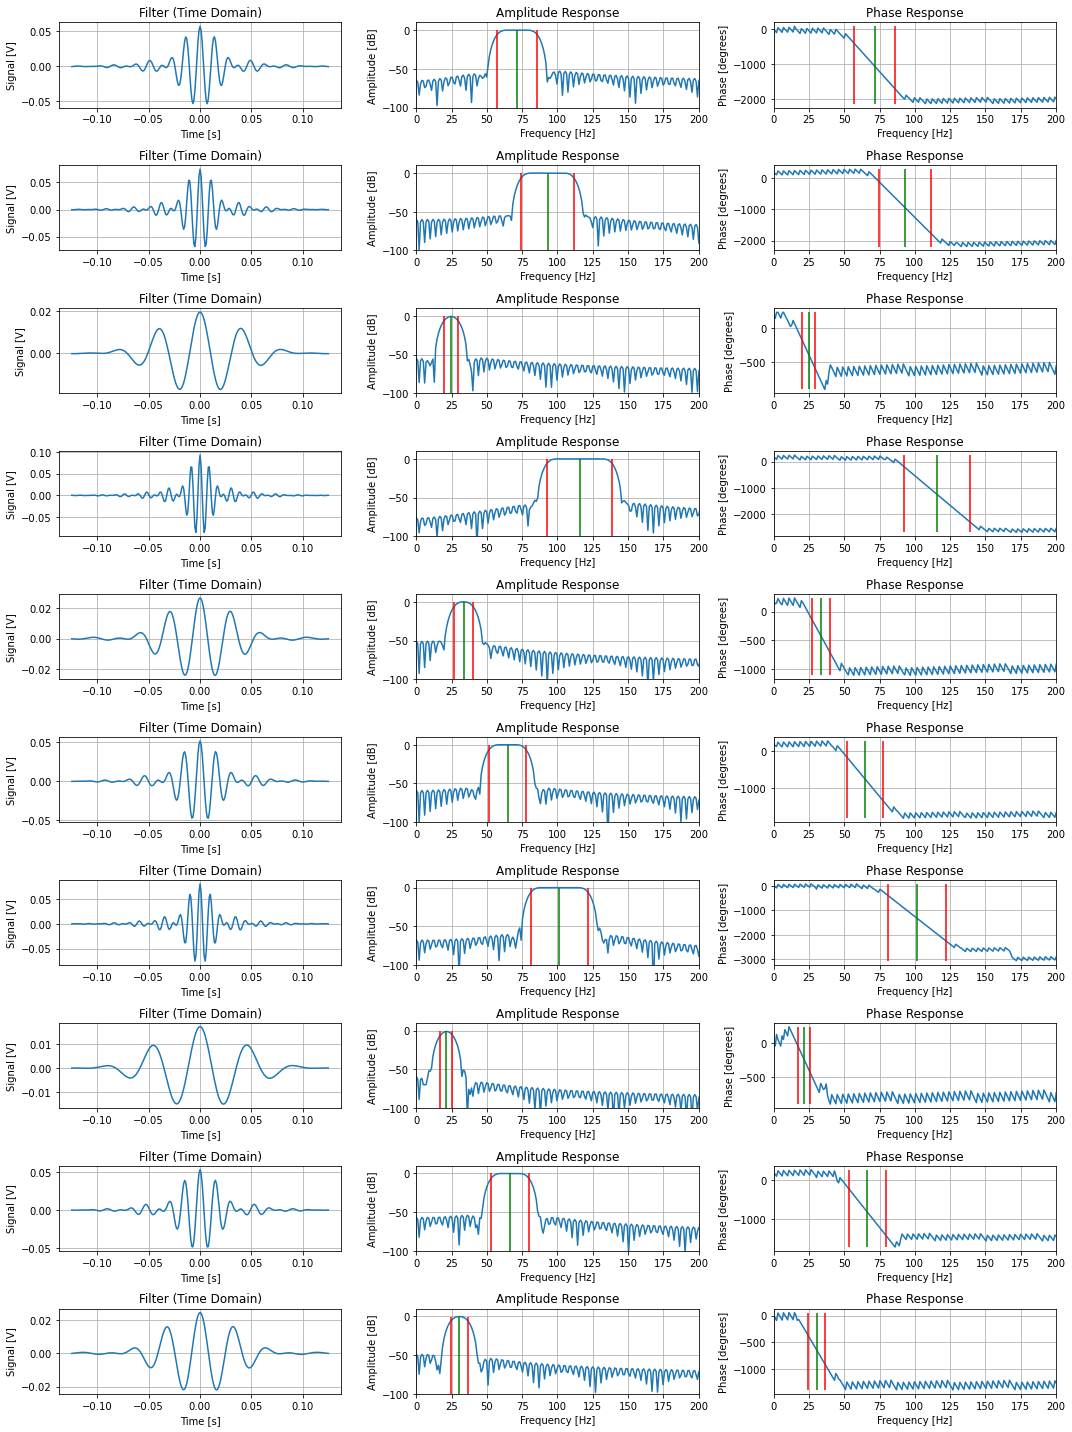

In [8]:
freqs, _, freq_low, freq_high = filter_hilbert._create_frequencies()
filt = filter_hilbert._create_filters(freq_low, freq_high).detach().numpy()
freqs, freq_low, freq_high = freqs.detach().numpy(), freq_low.detach().numpy(), freq_high.detach().numpy()
# filt = filter_hilbert.create_filters().detach().numpy()

fig, ax = plt.subplots(n_channels, 3, figsize=(15, 2*n_channels))
for i in range(n_channels):
    filter_coeffs = filt[i,0]
    w, h = sg.freqz(filter_coeffs, fs=srate * 2 * math.pi)
    freq = w / (2 * math.pi)
    amp = 20 * np.log10(np.abs(h))
    phase = np.unwrap(np.angle(h)) * 180 / math.pi
    
    
    ax[i,0].plot(filter_hilbert._scale.numpy()[0,0], filter_coeffs)
    ax[i,0].set_ylabel('Signal [V]')
    ax[i,0].set_xlabel('Time [s]')
    ax[i,0].set_title('Filter (Time Domain)')
    ax[i,0].grid(True)
    
    ax[i,1].plot(freq, amp)
    ax[i,1].vlines(freqs[i], np.min(amp), np.max(amp), colors='g')
    ax[i,1].vlines(freq_low[i], np.min(amp), np.max(amp), colors='r')
    ax[i,1].vlines(freq_high[i], np.min(amp), np.max(amp), colors='r')
    ax[i,1].set_ylim(-100, 10)
    ax[i,1].set_xlim(0, 200)
    ax[i,1].set_ylabel('Amplitude [dB]')
    ax[i,1].set_xlabel('Frequency [Hz]')
    ax[i,1].set_title('Amplitude Response')
    ax[i,1].grid(True)
    
    ax[i,2].plot(freq, phase)
    ax[i,2].vlines(freqs[i], np.min(phase), np.max(phase), colors='g')
    ax[i,2].vlines(freq_low[i], np.min(phase), np.max(phase), colors='r')
    ax[i,2].vlines(freq_high[i], np.min(phase), np.max(phase), colors='r')
    ax[i,2].set_xlim(0, 200)
    ax[i,2].set_xlabel('Frequency [Hz]')
    ax[i,2].set_ylabel('Phase [degrees]')
    ax[i,2].set_title('Phase Response')
    ax[i,2].grid(True)
    
plt.tight_layout()
plt.show()

# ComplexWaveletLayer

In [10]:
torch.manual_seed(0)

srate = 1000
n_channels = 10
freq = None
# bandwidth = None
bandwidth = 0.4
x = torch.randn(size=(n_channels, 3000,))

complex_wavelet = ComplexWaveletLayer(
    n_channels=n_channels,
    kernel_size=251,
    srate=srate,
    fmin_init=20,
    fmax_init=150,
    freq=freq,
    bandwidth=bandwidth,
)

y_ = complex_wavelet(x, return_filtered=True)
y = complex_wavelet(x)

assert x.shape == y.shape
y.mean().backward()
complex_wavelet.coef_freq.grad

tensor([1.1927e-04, 1.9305e-05, 1.0267e-04, 3.9073e-04, 2.5038e-04, 1.3117e-04,
        3.2226e-04, 2.5951e-04, 1.8618e-04, 3.0787e-04])

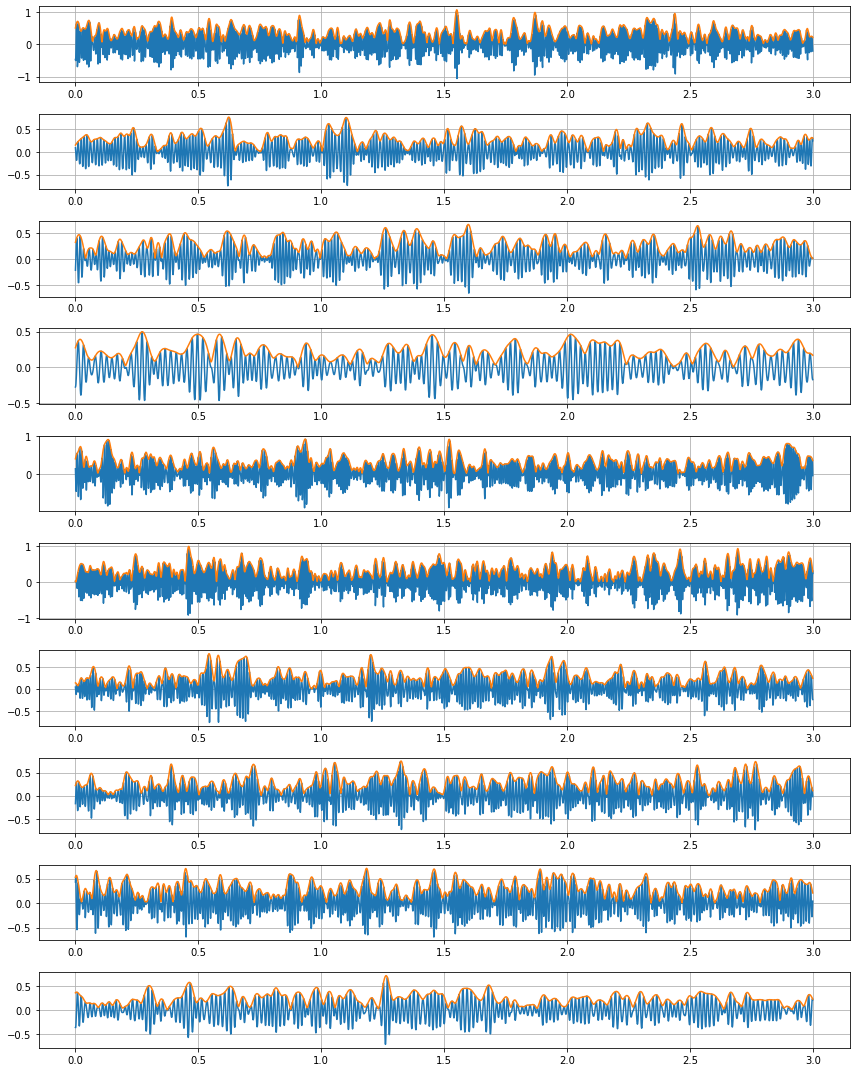

In [11]:
x_numpy = x.numpy()
y_numpy_ = y_.detach().numpy()
y_numpy = y.detach().numpy()
scale = np.arange(x_numpy.shape[-1]) / srate

fig, ax = plt.subplots(n_channels, 1, figsize=(12, 1.5*n_channels))
for i in range(n_channels):
    
    ax[i].plot(scale, y_numpy_[i])
    ax[i].plot(scale, y_numpy[i])
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    ax[i].set_title('')
    ax[i].grid(True)
    
plt.tight_layout()
plt.show()

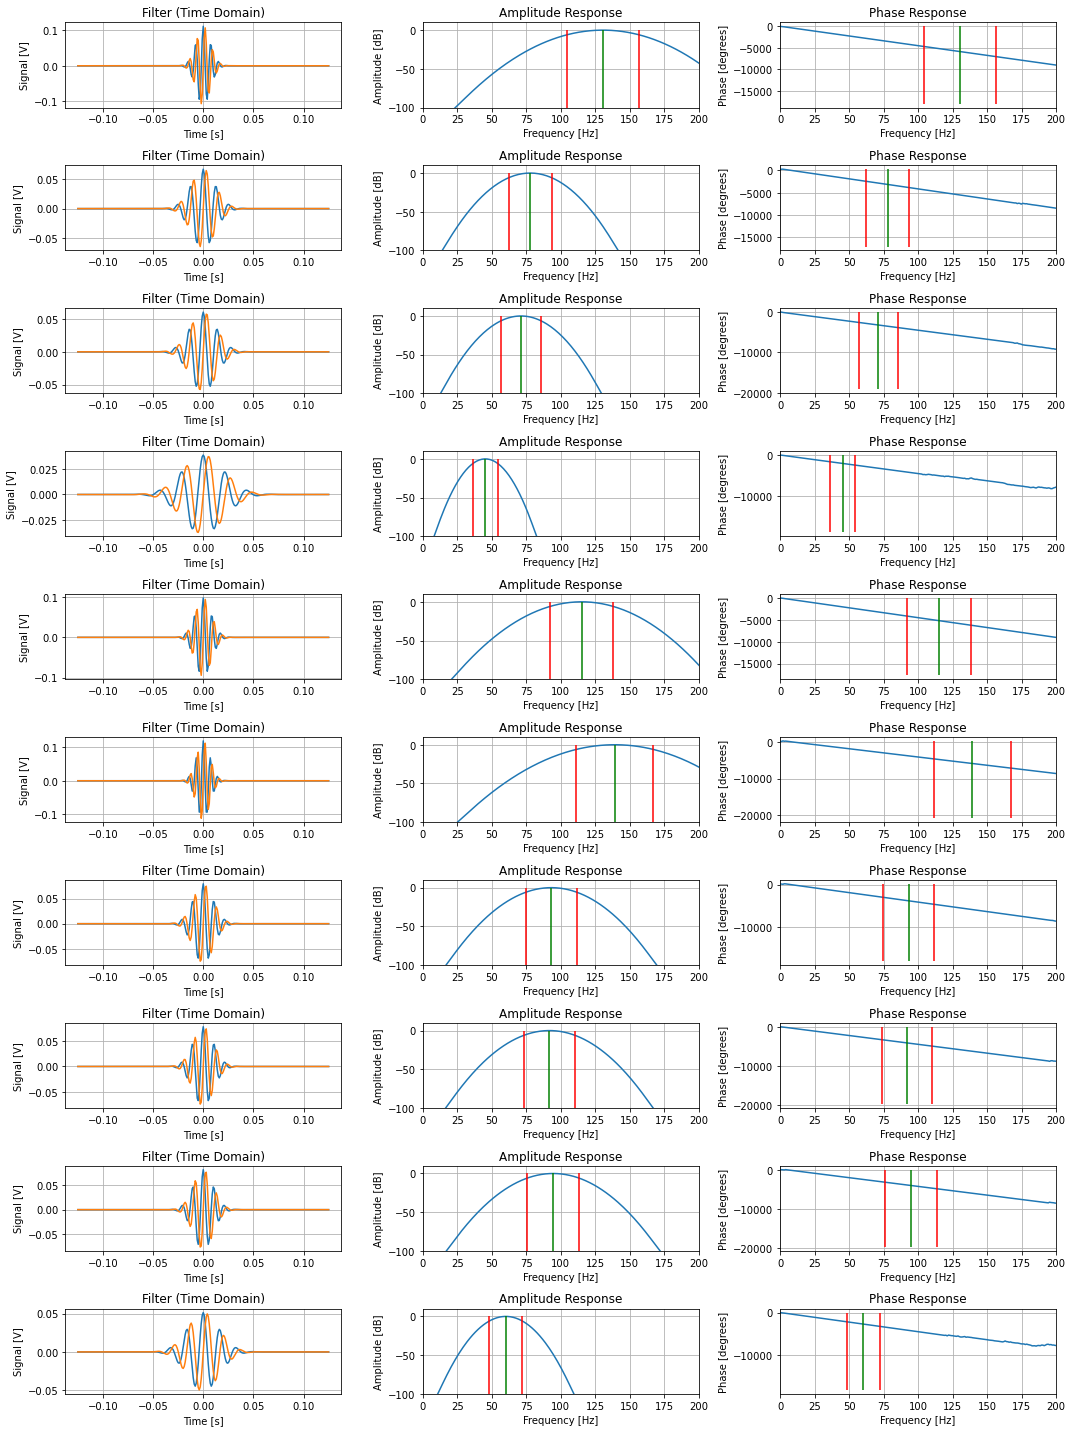

In [12]:
freqs, bandwidth, freq_low, freq_high = complex_wavelet._create_frequencies()
filt = complex_wavelet._create_filters(freqs, bandwidth).detach().numpy()
freqs, freq_low, freq_high = freqs.detach().numpy(), freq_low.detach().numpy(), freq_high.detach().numpy()

fig, ax = plt.subplots(n_channels, 3, figsize=(15, 2*n_channels))
for i in range(n_channels):
    filter_coeffs = filt[i,0]
    w, h = sg.freqz(filter_coeffs.real, fs=srate * 2 * math.pi)
    freq = w / (2 * math.pi)
    amp = 20*np.log10(np.abs(h) + 1e-6)
#     amp = np.abs(h)
    phase = np.unwrap(np.angle(h)) * 180 / math.pi
#     print(np.sum(amp > amp.max()/2) / freq[1] / freqs[0,0,0])
    
    ax[i,0].plot(complex_wavelet._scale.numpy()[0,0], filter_coeffs.real)
    ax[i,0].plot(complex_wavelet._scale.numpy()[0,0], filter_coeffs.imag)
    ax[i,0].set_ylabel('Signal [V]')
    ax[i,0].set_xlabel('Time [s]')
    ax[i,0].set_title('Filter (Time Domain)')
    ax[i,0].grid(True)
    
    ax[i,1].plot(freq, amp)
    ax[i,1].vlines(freqs[i], np.min(amp), np.max(amp), colors='g')
    ax[i,1].vlines(freq_low[i], np.min(amp), np.max(amp), colors='r')
    ax[i,1].vlines(freq_high[i], np.min(amp), np.max(amp), colors='r')
#     ax[i,1].set_ylim(0, 1)
    ax[i,1].set_ylim(-100, 10)
    ax[i,1].set_xlim(0, 200)
    ax[i,1].set_ylabel('Amplitude [dB]')
    ax[i,1].set_xlabel('Frequency [Hz]')
    ax[i,1].set_title('Amplitude Response')
    ax[i,1].grid(True)
    
    ax[i,2].plot(freq, phase)
    ax[i,2].vlines(freqs[i], np.min(phase), np.max(phase), colors='g')
    ax[i,2].vlines(freq_low[i], np.min(phase), np.max(phase), colors='r')
    ax[i,2].vlines(freq_high[i], np.min(phase), np.max(phase), colors='r')
    ax[i,2].set_xlim(0, 200)
    ax[i,2].set_xlabel('Frequency [Hz]')
    ax[i,2].set_ylabel('Phase [degrees]')
    ax[i,2].set_title('Phase Response')
    ax[i,2].grid(True)
    
plt.tight_layout()
plt.show()